In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)

In [2]:
os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_training/')
from ensemble_train import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_explanation/')
from ensemble_explanation import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_evaluation/')
from ensemble_evaluation import compare_ensembles_rocs_on_dataset,calculate_rocs_on_datasets,calculate_metrics_on_datasets,calculate_experiment_performance_on_datasets
from base_evaluation import * 

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preprocessing')
from ensemble_preprocessing import execute_ensemble_preprocessing

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preparation')
from ensemble_preparation import execute_ensemble_preparation

# Ensemble of CNNs + Demographics

## AD x CN

In [3]:
mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_23', 'CORONAL_43','SAGITTAL_26', 'COGTEST', 'DIAGNOSIS']

In [4]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm = ExplainableBoostingClassifier()
[ebm] = train_ensemble_models(df_train,label,[ebm])

patient_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv'
cutoff = get_optimal_threshold_for_model(ebm,df_validation,label)
df_patient_data = prepare_patient_data_for_explanations(patient_data_path,df_test,ebm,cutoff,
axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26')

df_patient_data_validation = prepare_patient_data_for_explanations(patient_data_path,df_validation,ebm,cutoff,
axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26')


/home/lucas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [5]:
from scipy.stats import mannwhitneyu

true_positives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'AD'")
true_negatives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'CN'")

false_positives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'CN'")
false_negatives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'AD'")

stats,pvalue = mannwhitneyu(true_positives['FINAL_PREDICTED_SCORE'],false_positives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is different between false positives and true positives because p-value = %.4f and  < 0.05" % pvalue)
print("false_positive mean(std) = %.4f (%.4g)" % (false_positives['FINAL_PREDICTED_SCORE'].mean(),false_positives['FINAL_PREDICTED_SCORE'].std()))
print("true_positive mean(std) = %.4f (%.4g)" % (true_positives['FINAL_PREDICTED_SCORE'].mean(),true_positives['FINAL_PREDICTED_SCORE'].std()))
print('------------------------------------')

stats,pvalue = mannwhitneyu(true_negatives['FINAL_PREDICTED_SCORE'],false_negatives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is not different between false negatives and true negatives because p-value = %.4f and > 0.05" % pvalue)
print("false_negative mean(std) = %.6f (%.6g)" % (false_negatives['FINAL_PREDICTED_SCORE'].mean(),false_negatives['FINAL_PREDICTED_SCORE'].std()))
print("true_negative mean(std) = %.6f (%.6g)" % (true_negatives['FINAL_PREDICTED_SCORE'].mean(),true_negatives['FINAL_PREDICTED_SCORE'].std()))

The predicted scores distribution is different between false positives and true positives because p-value = 0.0000 and  < 0.05
false_positive mean(std) = 0.0818 (0.2451)
true_positive mean(std) = 0.5485 (0.4679)
------------------------------------
The predicted scores distribution is not different between false negatives and true negatives because p-value = 0.0750 and > 0.05
false_negative mean(std) = 0.000001 (3.27109e-07)
true_negative mean(std) = 0.000001 (9.79869e-07)


In [6]:
explainer = EnsembleExplainer(model=ebm,ensemble_data=df_test,patients_data=df_patient_data)

In [7]:
true_positives.query("FINAL_PREDICTED_SCORE > 0.8").head()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I250665,66.7,MALE,20,NO,WHITE,NO,0.999995,0.998159,0.997097,AD,0.975890,AD
I254813,77.7,FEMALE,19,NO,WHITE,NO,0.999836,0.998464,0.000272,AD,0.963038,AD
I280642,73.7,MALE,18,NO,WHITE,NO,0.999994,0.902817,0.141957,AD,0.985784,AD
I300256,66.8,MALE,12,NO,WHITE,NO,0.000002,0.830546,1.000000,AD,0.896259,AD
I306751,75.3,MALE,20,NO,WHITE,NO,0.997876,0.918308,0.999974,AD,0.999962,AD


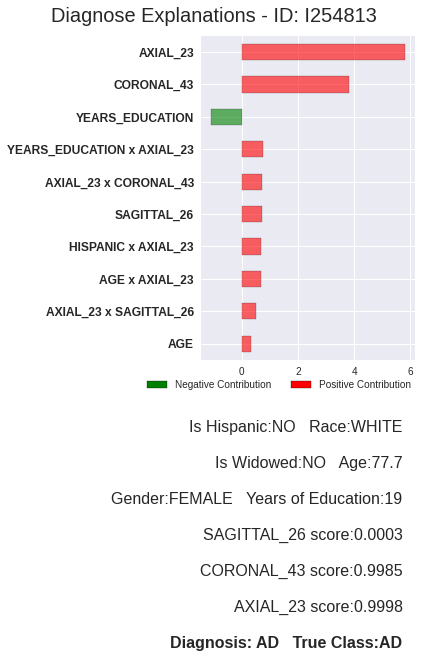

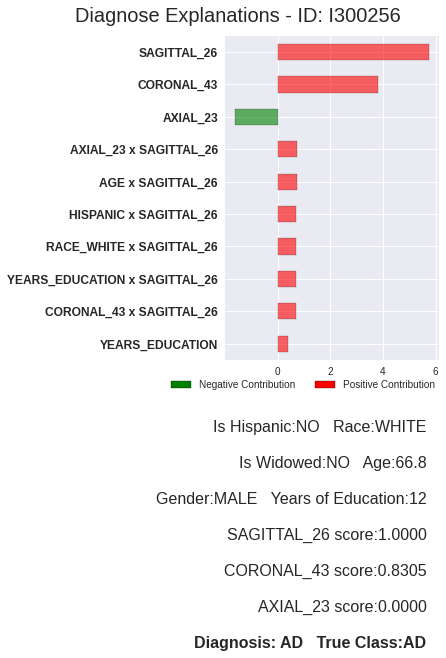

In [9]:
explainer = EnsembleExplainer(model=ebm,ensemble_data=df_test,patients_data=df_patient_data)
explanation_fig = explainer.explain(sample_id='I254813')
explanation_fig = explainer.explain(sample_id='I300256')

In [12]:
true_negatives.query("FINAL_PREDICTED_SCORE > 0.000001").head()
true_negatives.head()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I218436,77.7,FEMALE,16,NO,WHITE,NO,0.000000,1.654170e-02,2.000000e-07,CN,1.000000e-07,CN
I222684,72.6,FEMALE,18,NO,BLACK,NO,0.000004,2.600000e-06,0.000000e+00,CN,1.000000e-07,CN
I233461,66.5,MALE,16,NO,WHITE,NO,0.000000,6.000000e-06,0.000000e+00,CN,1.000000e-07,CN
I235656,70.2,FEMALE,14,NO,WHITE,NO,0.000095,6.032000e-04,9.000000e-06,CN,1.000000e-07,CN
I241342,84.4,MALE,18,NO,WHITE,NO,0.000000,1.000000e-07,1.100000e-06,CN,1.000000e-07,CN


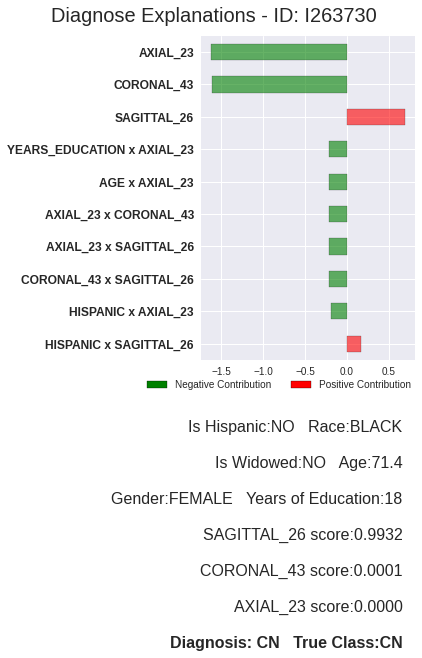

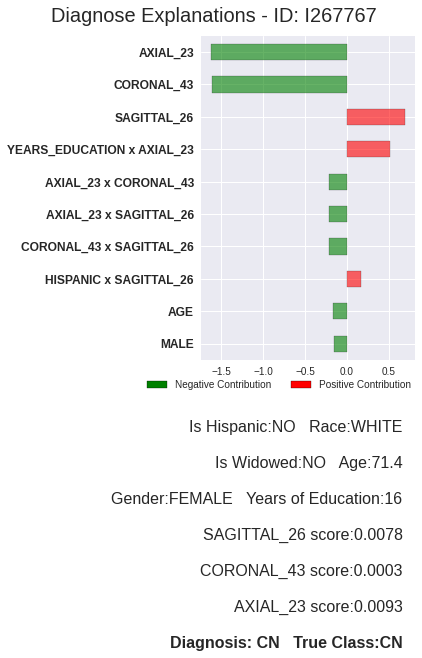

In [13]:
explanation_fig = explainer.explain(sample_id='I263730')
explanation_fig = explainer.explain(sample_id='I267767')

In [14]:
false_positives.tail()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I765014,73.7,FEMALE,16,NO,WHITE,NO,7.374784e-01,0.147058,0.000013,CN,0.000678,AD
I765420,70.9,MALE,15,NO,WHITE,NO,1.000000e-07,0.799803,0.000000,CN,0.000020,AD
I765428,84.2,MALE,16,NO,WHITE,NO,6.920730e-02,0.005469,0.354953,CN,0.000026,AD
I775815,71.4,FEMALE,16,NO,WHITE,NO,6.029908e-01,0.000165,0.000058,CN,0.000831,AD
I845477,84.2,MALE,16,NO,WHITE,NO,2.880000e-05,0.984199,0.046758,CN,0.001272,AD


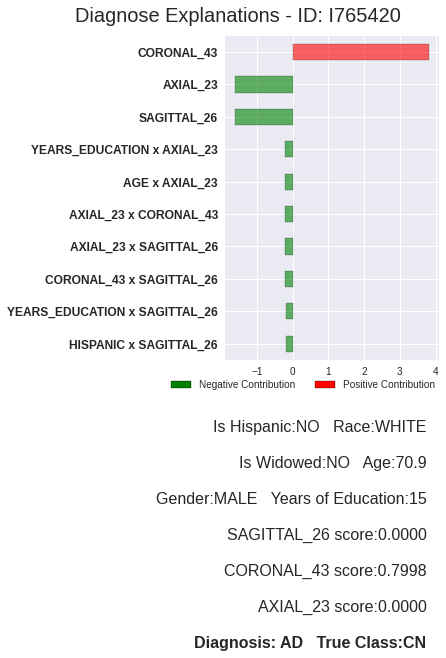

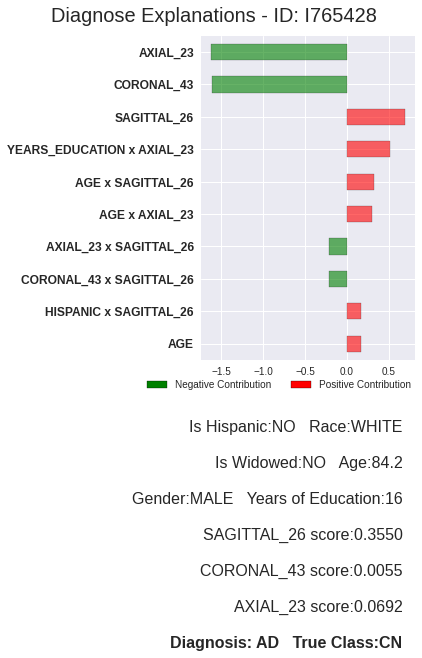

In [15]:
explanation_fig = explainer.explain(sample_id='I765420')
explanation_fig = explainer.explain(sample_id='I765428')

Here, even though the model got an output of AD, a doctor can still question its result by analysing the feature importances found for specific cases and make his/her diagnosis based on that.  It appears that at even with weak evidences, that might be only one slice indicating the disease and the rest of the features indicating a healthy subject, the model diagnoses a patient with the Alzheimer's Disease. Moreover, recalling the performance metrics for the ensemble at Table [REF XXX], we see that due to its low precision and high recall, the model is less selective and more sensitive. Looking from a common sense perspective one could affirm that making a majority vote on each individual prediction would be sufficient to resolve this supost issue, however the final diagnosis will always be given by a specialist in the field, considering their experitse in the field. Lastly, it is clear that although a false positive diagnosis could cause some stress for the patient, the doctor could request additional exams in case they are not so sure about the models outcome. This scenario is still preferred over a false negative diagnosis that could go untreated, leading to a loss of quality of life and other more severe outcomes.

In [16]:
false_negatives

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I326594,72.7,FEMALE,12,NO,WHITE,NO,0.052931,0.107995,0.000001,AD,5.000000e-07,CN
I327035,69.2,FEMALE,18,NO,ASIAN,NO,0.000741,0.000560,0.002840,AD,6.000000e-07,CN
I364665,69.2,FEMALE,18,NO,ASIAN,NO,0.001182,0.000002,0.006307,AD,6.000000e-07,CN
I388021,66.1,FEMALE,16,YES,WHITE,NO,0.002421,0.000044,0.755734,AD,9.000000e-07,CN
I394764,73.8,MALE,12,YES,WHITE,NO,0.000037,0.034919,0.000006,AD,0.000000e+00,CN


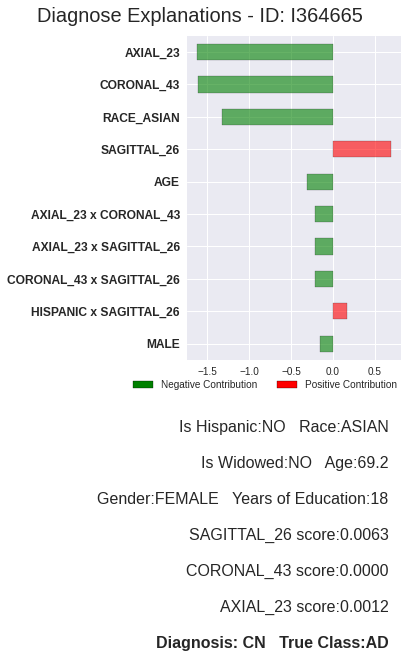

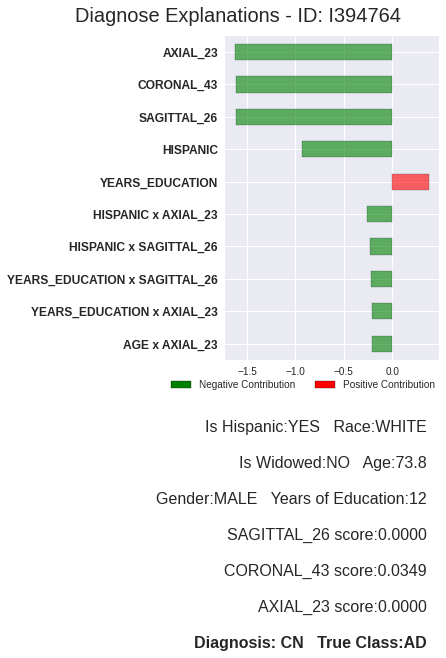

In [17]:
explanation_fig = explainer.explain(sample_id='I364665')
explanation_fig = explainer.explain(sample_id='I394764')

# explanation_fig = explainer.explain(sample_id='I326594')
# explanation_fig = explainer.explain(sample_id='I327035')
# explanation_fig = explainer.explain(sample_id='I388021')


Here the race features contribute for a negative diagnosis. On a first moment, it might be intuitive to think that different racial traits might lead to different diagnosis. However, looking at the preprocessed data at Table [REF XXX] we see that the vast majority of people are white and non hispanic, and a really small portion of data contains black people, hispanics, asians and other races. In other words, the minority races are underrepresented. Also, the global explanations for this ensemble show the race features with really low importance. Therefore, it is possible to conclude that these features should not be used, since the race distribution is extremely unbalanced, potentially leading to biased predictions and explanations. 

Not only that, but Alzheimer's Disease diagnosis assisted by Machine Learning techniques should be taken into further investigation considering specific race cohorts in order to assess both models performance and model explainability, since it is vastly know that minorities in general have less access to education and healthcare. This cohoborates with a recent study in the USA, that showed that although black people are twice as likely to develop some form of dementia, they are less likely to be diagnosed, due to social disparities [REF PAPER https://pubmed.ncbi.nlm.nih.gov/34854531/]

By removing the Race features from the dataset and re-running this ensemble experiment, it was possible to obtain an AUC of 0.942 and F1 of 0.683 for the test set. This result is only shown here on purpose, to raise the attention to the importance of analysing model explanations rather than just its performance.



### Patient Diagnosis Figure

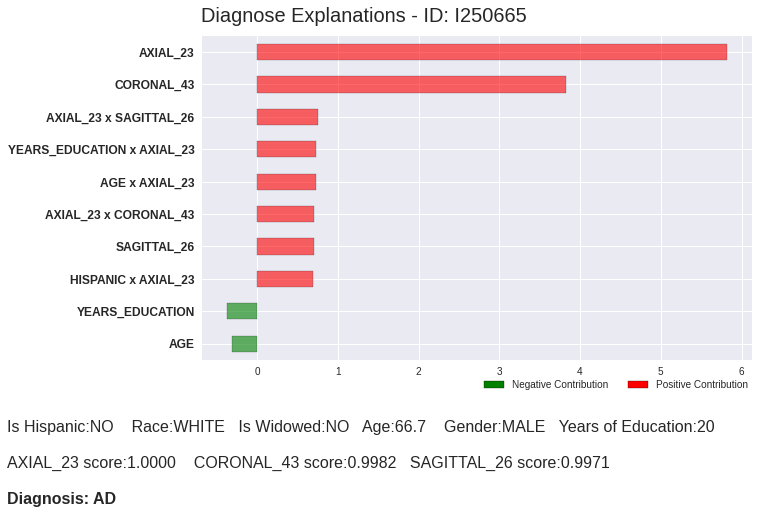

In [19]:
explanation_fig = explainer.explain(sample_id='I250665',show_true_diagnosis=False,figsize=(9,5))

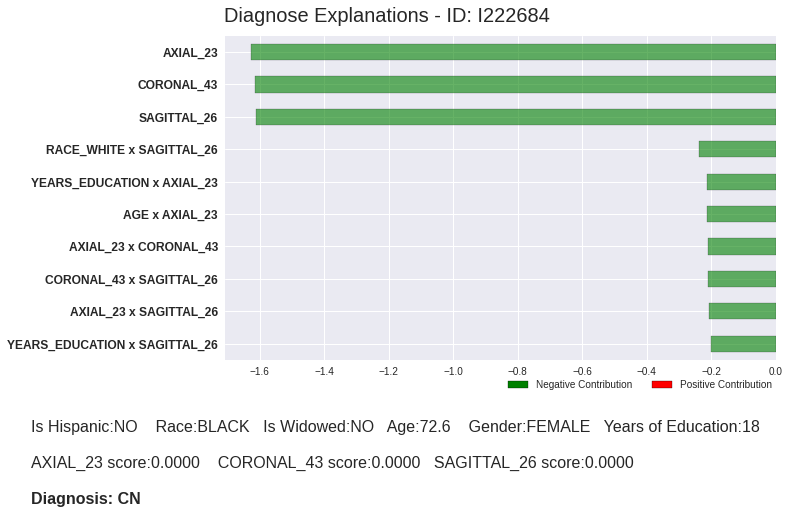

In [20]:
explanation_fig = explainer.explain(sample_id='I222684',show_true_diagnosis=False,figsize=(9,5))

## MCI x CN

In [21]:
mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_8', 'CORONAL_70','SAGITTAL_50', 'COGTEST', 'DIAGNOSIS']

In [22]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm = ExplainableBoostingClassifier()
[ebm] = train_ensemble_models(df_train,label,[ebm])

patient_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv'
cutoff = get_optimal_threshold_for_model(ebm,df_validation,label)
df_patient_data = prepare_patient_data_for_explanations(patient_data_path,df_test,ebm,cutoff,positive_case='MCI',
axial_label='AXIAL_8',coronal_label='CORONAL_70',sagittal_label='SAGITTAL_50')

df_patient_data_validation = prepare_patient_data_for_explanations(patient_data_path,df_validation,ebm,cutoff,positive_case='MCI',
axial_label='AXIAL_8',coronal_label='CORONAL_70',sagittal_label='SAGITTAL_50')

/home/lucas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [23]:
from scipy.stats import mannwhitneyu

true_positives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'MCI'")
true_negatives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'CN'")

false_positives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'CN'")
false_negatives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'MCI'")

stats,pvalue = mannwhitneyu(true_positives['FINAL_PREDICTED_SCORE'],false_positives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is the same between false positives and true positives because p-value = %.4f and  > 0.05" % pvalue)
print("false_positive mean(std) = %.4f (%.4g)" % (false_positives['FINAL_PREDICTED_SCORE'].mean(),false_positives['FINAL_PREDICTED_SCORE'].std()))
print("true_positive mean(std) = %.4f (%.4g)" % (true_positives['FINAL_PREDICTED_SCORE'].mean(),true_positives['FINAL_PREDICTED_SCORE'].std()))
print('------------------------------------')

stats,pvalue = mannwhitneyu(true_negatives['FINAL_PREDICTED_SCORE'],false_negatives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is different between false negatives and true negatives because p-value = %.4f and < 0.05" % pvalue)
print("false_negative mean(std) = %.6f (%.6g)" % (false_negatives['FINAL_PREDICTED_SCORE'].mean(),false_negatives['FINAL_PREDICTED_SCORE'].std()))
print("true_negative mean(std) = %.6f (%.6g)" % (true_negatives['FINAL_PREDICTED_SCORE'].mean(),true_negatives['FINAL_PREDICTED_SCORE'].std()))

The predicted scores distribution is the same between false positives and true positives because p-value = 0.1195 and  > 0.05
false_positive mean(std) = 0.8397 (0.3442)
true_positive mean(std) = 0.8437 (0.3639)
------------------------------------
The predicted scores distribution is different between false negatives and true negatives because p-value = 0.0000 and < 0.05
false_negative mean(std) = 0.000000 (3.12872e-07)
true_negative mean(std) = 0.000000 (2.03122e-07)


In [24]:
cutoff

5.735218380017766e-06

In [25]:
explainer = EnsembleExplainer(model=ebm,ensemble_data=df_test,patients_data=df_patient_data,
axial_label='AXIAL_8',coronal_label='CORONAL_70',sagittal_label='SAGITTAL_50')

In [26]:
true_positives.query("FINAL_PREDICTED_SCORE > 0.8").head(10)

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_8,CORONAL_70,SAGITTAL_50,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I200355,74.3,MALE,18,NO,WHITE,NO,0.708039,0.467779,0.543163,MCI,0.999997,MCI
I222947,76.4,FEMALE,18,NO,WHITE,NO,0.667947,0.542588,0.615082,MCI,0.999959,MCI
I223019,83.2,MALE,12,NO,WHITE,NO,0.960907,0.628587,0.597936,MCI,1.000000,MCI
I223044,68.0,MALE,13,NO,WHITE,NO,0.948428,0.623965,0.656843,MCI,1.000000,MCI
I223077,76.1,MALE,12,NO,WHITE,NO,0.947150,0.628490,0.395822,MCI,0.999988,MCI
I223497,64.8,MALE,16,NO,WHITE,NO,0.879481,0.523864,0.625466,MCI,1.000000,MCI
I223523,70.6,MALE,16,NO,WHITE,NO,0.596836,0.563219,0.681464,MCI,0.999989,MCI
I236970,66.0,MALE,18,YES,OTHER RACES,NO,0.565528,0.547837,0.668650,MCI,0.999969,MCI
I236978,69.1,MALE,16,NO,WHITE,NO,0.922857,0.547264,0.628412,MCI,1.000000,MCI


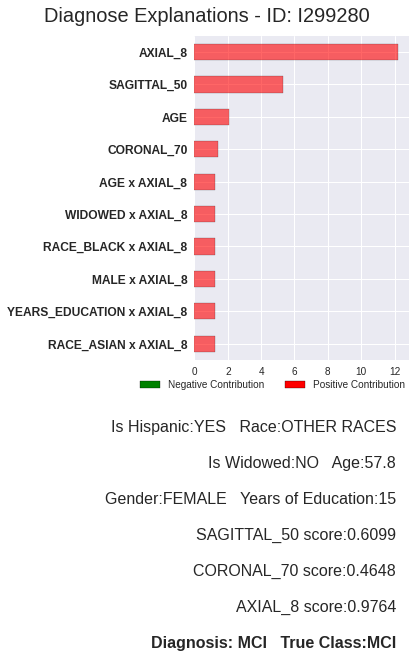

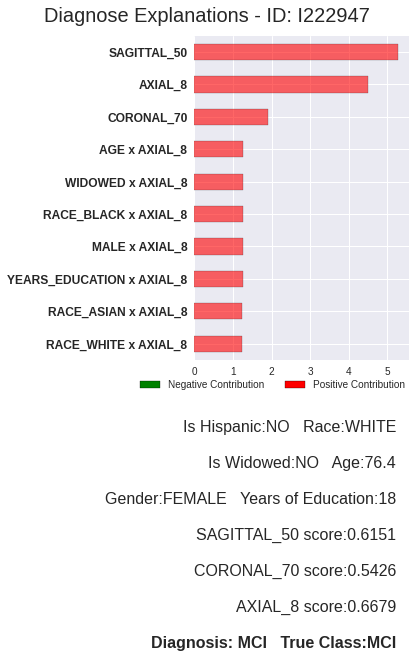

In [27]:
explanation_fig = explainer.explain(sample_id='I299280')
explanation_fig = explainer.explain(sample_id='I222947')

In [28]:
true_negatives.head(10)

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_8,CORONAL_70,SAGITTAL_50,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I218436,77.7,FEMALE,16,NO,WHITE,NO,0.093217,5.877860e-01,0.279977,CN,0.000000e+00,CN
I222684,72.6,FEMALE,18,NO,BLACK,NO,0.000000,0.000000e+00,0.001418,CN,0.000000e+00,CN
I233461,66.5,MALE,16,NO,WHITE,NO,0.000000,0.000000e+00,0.001405,CN,0.000000e+00,CN
I235656,70.2,FEMALE,14,NO,WHITE,NO,0.000000,2.900000e-06,0.016550,CN,0.000000e+00,CN
I265250,72.6,FEMALE,18,NO,BLACK,NO,0.000000,0.000000e+00,0.002007,CN,0.000000e+00,CN
I267759,71.7,FEMALE,15,NO,WHITE,NO,0.000000,1.245000e-04,0.002404,CN,0.000000e+00,CN
I267767,71.4,FEMALE,16,NO,WHITE,NO,0.446185,5.058356e-01,0.454064,CN,0.000000e+00,CN
I270043,73.7,FEMALE,16,NO,WHITE,NO,0.076328,4.516752e-01,0.552033,CN,5.000000e-07,CN
I272687,70.2,FEMALE,14,NO,WHITE,NO,0.000000,0.000000e+00,0.013216,CN,0.000000e+00,CN


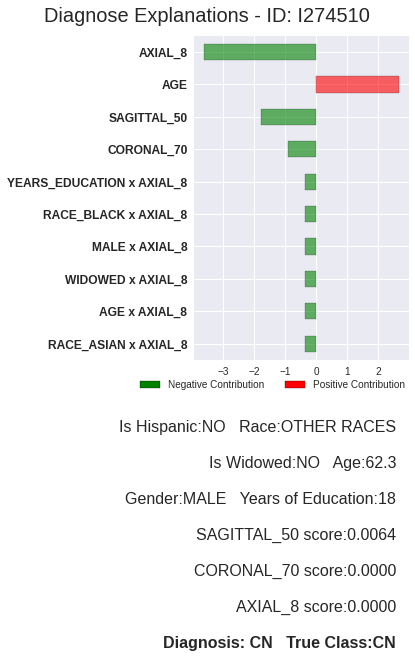

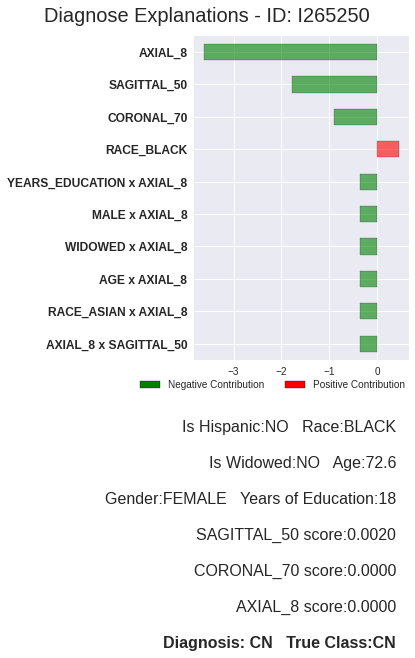

In [29]:
explanation_fig = explainer.explain(sample_id='I274510')
explanation_fig = explainer.explain(sample_id='I265250')

Curiously, we see on Figure [REF XXX] the Age playing an important positive contribution to the diagnosis, even being a person with less than 70 years. Figure [REF XXX] also shows another unintuitive explanation for the features. Although all MRI diagnoses show really low scores, and thus, low probability of being MCI, we see the race black indicating a positive contribution to the diagnosis, which in this case, is misleading. This correlates to the previous local explanations for false positives AD cases where we see other races indicating a contrary direction of the MRI diagnosis.

In [30]:
false_positives.tail()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_8,CORONAL_70,SAGITTAL_50,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I388449,72.9,FEMALE,16,NO,WHITE,YES,0.720009,0.570983,0.429574,CN,0.999904,MCI
I388460,68.1,MALE,18,NO,WHITE,NO,0.667790,0.485983,0.457552,CN,0.966216,MCI
I398319,59.7,FEMALE,16,NO,WHITE,NO,0.683240,0.344353,0.511409,CN,0.862215,MCI
I414375,67.2,MALE,20,NO,WHITE,NO,0.653700,0.555912,0.538459,CN,0.997492,MCI
I414452,79.5,FEMALE,20,NO,WHITE,YES,0.630763,0.552131,0.609697,CN,0.999992,MCI


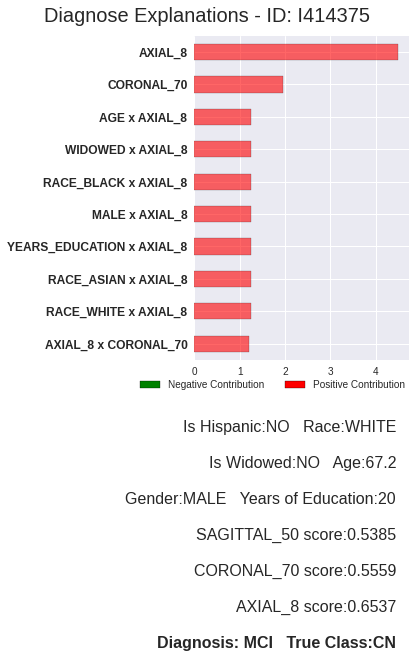

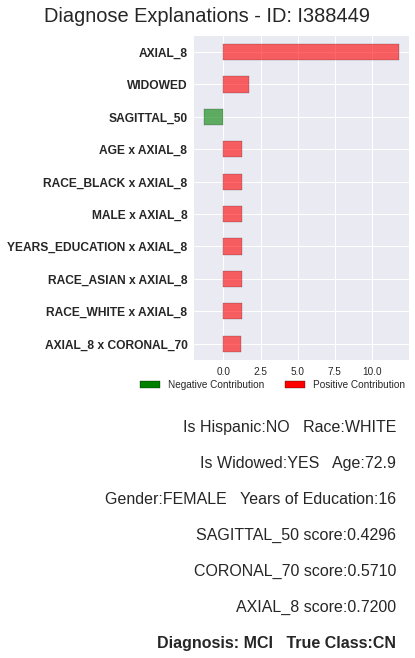

In [31]:
explanation_fig = explainer.explain(sample_id='I414375')
explanation_fig = explainer.explain(sample_id='I388449')

Here, even though the model got an output of AD, a doctor can still question its result by analysing the feature importances found for specific cases and make his/her diagnosis based on that.  It appears that at even with weak evidences, that might be only one slice indicating the disease and the rest of the features indicating a healthy subject, the model diagnoses a patient with the Alzheimer's Disease. Moreover, recalling the performance metrics for the ensemble at Table [REF XXX], we see that due to its low precision and high recall, the model is less selective and more sensitive. Looking from a common sense perspective one could affirm that making a majority vote on each individual prediction would be sufficient to resolve this supost issue, however the final diagnosis will always be given by a specialist in the field, considering their experitse in the field. Lastly, it is clear that although a false positive diagnosis could cause some stress for the patient, the doctor could request additional exams in case they are not so sure about the models outcome. This scenario is still preferred over a false negative diagnosis that could go untreated, leading to a loss of quality of life and other more severe outcomes.

In [32]:
false_negatives

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_8,CORONAL_70,SAGITTAL_50,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I223267,59.5,FEMALE,16,NO,WHITE,NO,0.361821,0.545042,0.517589,MCI,2.000000e-07,CN
I223326,70.4,MALE,20,NO,WHITE,NO,0.282466,0.411501,0.544013,MCI,0.000000e+00,CN
I225427,75.2,MALE,18,NO,WHITE,NO,0.193400,0.472386,0.470693,MCI,0.000000e+00,CN
I272728,62.8,FEMALE,14,NO,WHITE,NO,0.152547,0.515305,0.464063,MCI,1.000000e-07,CN
I280572,74.4,MALE,16,NO,WHITE,NO,0.374867,0.266685,0.407717,MCI,0.000000e+00,CN
I296327,67.3,FEMALE,14,NO,BLACK,NO,0.038589,0.427799,0.282520,MCI,0.000000e+00,CN
I296329,67.8,MALE,20,NO,WHITE,NO,0.031395,0.410980,0.529691,MCI,0.000000e+00,CN
I300950,77.9,MALE,20,NO,WHITE,NO,0.409084,0.445178,0.548592,MCI,1.000000e-06,CN
I300955,70.8,MALE,20,NO,WHITE,NO,0.272399,0.546419,0.010793,MCI,0.000000e+00,CN


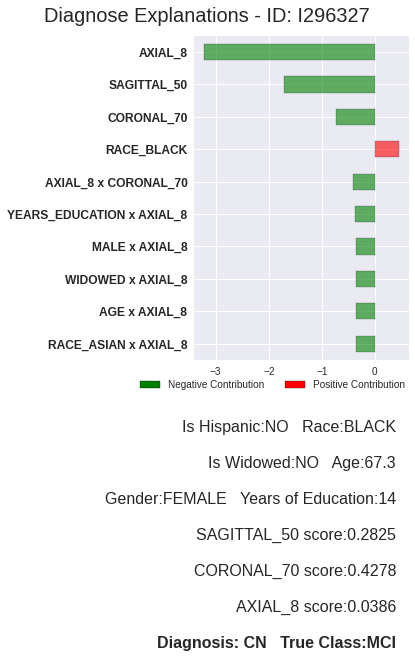

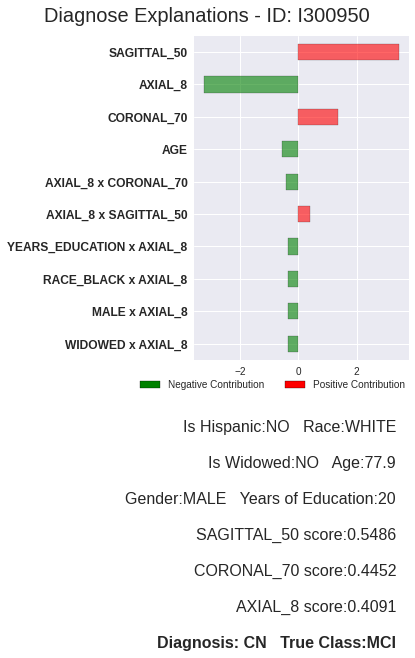

In [33]:
explanation_fig = explainer.explain(sample_id='I296327')
explanation_fig = explainer.explain(sample_id='I300950')

Figure [REF XXX] shows a somewhat confusing diagnostic, where the sagittal and axial slices have opposite importances, but almost the same absolute value, hence a further look at their MRI explanations could help to enlight the diagnosis. Figure [REF XXX] shows the race as the only factor that contributed positively to the diagnosis, while all MRI slices showed the contrary. This is an additional warning on how race features should be carefully used and how representing equally different races is important to a fair diagnosis. Moreover, by looking at all the explanations so far, it is suggested that since patients from the race white compose a large number of data samples, the model have sufficient information to not rely on the race information. Unfortunately, the same cannot be said about the minorities. 

### Patient Explanation Diagnosis

In [34]:
explainer = EnsembleExplainer(model=ebm,ensemble_data=df_test,patients_data=df_patient_data,
axial_label='AXIAL_8',coronal_label='CORONAL_70',sagittal_label='SAGITTAL_50')

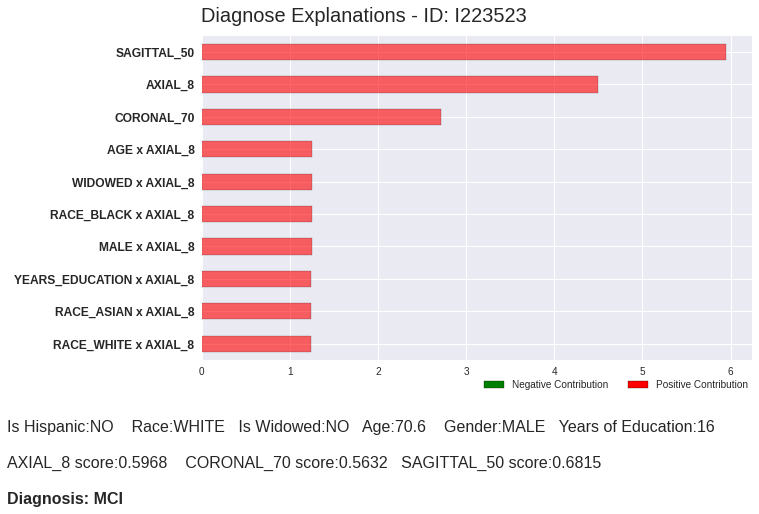

In [35]:
explanation_fig = explainer.explain(sample_id='I223523',figsize=(9,5),show_true_diagnosis=False)

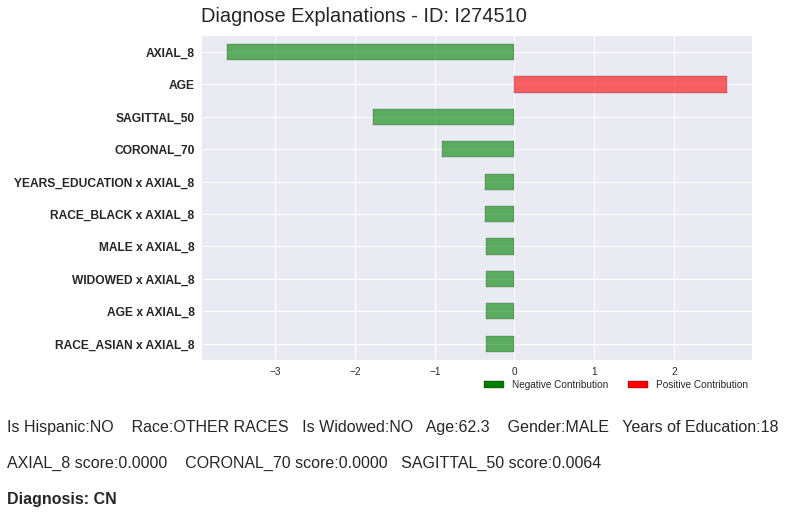

In [36]:
explanation_fig = explainer.explain(sample_id='I274510',figsize=(9,5),show_true_diagnosis=False)